## 題目
### Collect at least two customized rule-based patterns with indices.
詳見完整講義

新增OneLeafKnowAutumn(一葉知秋)

新增GodGuideTheWay(仙人指路)

### 一、程式碼

* 所有檔案: util_pattern.py、 Process.py、Detect.py、Main.py

#### 1. util_pattern.py

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import mplfinance.original_flavor as mpf
def pattern(df, signal, timeScale, path):         
    # 設定xy軸座標值、圖片標題大小       
    fontsize = 15
    plt.rcParams['xtick.labelsize'] = fontsize  
    plt.rcParams['ytick.labelsize'] = fontsize 
    plt.rcParams['axes.titlesize'] = fontsize           

    # 設定圖片的大小
    fig = plt.figure(figsize=(18, 12))
    ax = plt.subplot2grid((1, 1), (0, 0))          

    # 設定圖片背景為網格
    plt.grid()

    # 將x座標軸數值設為日期
    ax.set_xticks(range(10))
    ax.set_xticklabels(df['date'])      

    # 將x坐標軸數值旋轉45度
    locs, labels = plt.xticks() 
    plt.setp(labels , rotation = 45)

    # 繪出前幾根K棒的趨勢線
    global end_idx
    if signal == ('OneLeafKnowAutumn' or 'GodGuideTheWay'):
        end_idx = 7
    elif signal == ('ShootingStar' or 'InvertHammer'):
        end_idx = 9
    elif signal == ('BearishHarami' or 'BearishEngulfing' or 'BullishHarami' or 'BullishEngulfing'):
        end_idx = 8 
    y = df['close'].iloc[0:end_idx].values.reshape(-1, 1)
    x = np.array(range(1, end_idx + 1)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)        
    ax.plot(y_pred, label='Trend')          

    # 繪出k棒 
    arr = np.c_[range(df.shape[0]), df[['open', 'high', 'low', 'close']].values]
    mpf.candlestick_ohlc(ax, arr, width=0.4, alpha=1, colordown='#53c156', colorup='#ff1717')    

    # 設定圖例位置與大小
    ax.legend(loc = 'best', prop = {'size': fontsize})

    # 設定圖片標題名字
    title_name = signal + '_' + timeScale
    ax.set_title(title_name)

    # 上調整個圖片的位置
    fig.subplots_adjust(bottom = 0.35)

    # # 儲存圖片
    # name = path + '/' + signal + '_' + timeScale + '.png'
    # plt.savefig(name)     
    
    # 印出圖片
    plt.show()

    # 不要印出圖片
    # plt.close('all')  

In [14]:
!pip -- install mplfinance

#### Process.py

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression


class Process(object):
    def __init__(self, filename, timeScale):
        self.data = pd.read_csv(filename)
        self.timeScale = timeScale


    def preprocessing(self):
        # 將欄位名稱全部轉成小寫
        for i in self.data.columns.values:
            self.data.rename(columns={i : i.lower()}, inplace=True)       
        # 將日期從名目轉成時間尺度，並將其設為索引
        self.data['timestamp'] = pd.to_datetime(self.data['date'], format="%d.%m.%Y %H:%M:%S.%f")
        self.data.set_index('timestamp', inplace=True)

    
    def timeConvert(self):
        # 將資料的時間尺度轉成分鐘資料
        df = pd.DataFrame(self.data['date'])
        df['low'] = self.data['low'].resample(self.timeScale, label='right', closed='right').min()
        df['high'] = self.data['high'].resample(self.timeScale, label='right', closed='right').max()
        df['close'] = self.data['close'].resample(self.timeScale, label='right', closed='right').last()
        df['open'] = self.data['open'].resample(self.timeScale, label='right', closed='right').first()
        self.data = df[1:-1]
        self.data.dropna(inplace=True)
    

    def percentile(self, series):
        t = series.iloc[-1]
        p = stats.percentileofscore(series, t, kind='strict')    
        return p


    def addFeature(self):
        # realbody: k棒長度，close - open
        # direction: k棒漲跌，realbody 的正負號
        # ushadow_width: 上引線長度，恆為正。如果k棒下跌，為high - open；如果k棒上跌，為high - close
        # lshadow_width: 下引線長度，恆為正。如果k棒下跌，為close - low；如果k棒上跌，為open - low
        # ushadow_per: 上引線長度在前50根k棒中的PR值
        # lshadow_per: 下引線長度在前50根k棒中的PR值
        # realbody_per: K棒長度在前50根k棒中的PR值
        self.data['realbody'] = self.data['close'] - self.data['open']
        self.data['direction'] = np.sign(self.data['realbody'])
        self.data['ushadow_width'], self.data['lshadow_width'] = 0, 0
        self.data.loc[self.data['realbody'] <= 0, 'ushadow_width'] = self.data.loc[self.data['realbody'] <= 0, 'high'] - self.data.loc[self.data['realbody'] <= 0, 'open']
        self.data.loc[self.data['realbody'] > 0, 'ushadow_width'] = self.data.loc[self.data['realbody'] > 0, 'high'] - self.data.loc[self.data['realbody'] > 0, 'close']
        self.data.loc[self.data['realbody'] <= 0, 'lshadow_width'] = self.data.loc[self.data['realbody'] <= 0, 'close'] - self.data.loc[self.data['realbody'] <= 0, 'low']
        self.data.loc[self.data['realbody'] > 0, 'lshadow_width'] = self.data.loc[self.data['realbody'] > 0, 'open'] - self.data.loc[self.data['realbody'] > 0, 'low']
        self.data['ushadow_per'] = self.data['ushadow_width'].rolling(50).apply(self.percentile, raw=False)
        self.data['lshadow_per'] = self.data['lshadow_width'].rolling(50).apply(self.percentile, raw=False)
        self.data['realbody_per'] = abs(self.data['realbody']).rolling(50).apply(self.percentile, raw=False)        
        self.data.dropna(inplace = True)
        return self.data

#### 3. Detect.py

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


class Detect(object):
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.timeScale = None
    

    def trending(self, series):
        # 以線性回歸的斜率決定趨勢，斜率為正，趨勢為正向，輸出1；反之為趨勢為負向，輸出-1。
        # 斜率為0，輸出0
        y = series.values.reshape(-1,1)
        x = np.array(range(1, series.shape[0] + 1)).reshape(-1,1)
        model = LinearRegression()
        model.fit(x, y)
        slope = model.coef_
        if slope > 0:
            return 1
        elif slope == 0:
            return 0
        else:
            return -1
    

    def OneLeafKnowAutumn(self, df):
        # 2. 第9根上漲
        # 3. 第10根下跌
        # 4. 第9根長度在前50根中PR值大於等於70
        # 5. 第10根長度在前50根中PR值小於等於30
        # 6. 第10根收盤價小於第9根body中央
        # 8. 第10根開盤價大於第9根body中央
        cond1 = (df['direction'].iloc[-2] > 0)
        cond2 = (df['direction'].iloc[-1] < 0)
        cond3 = (df['realbody_per'].iloc[-2] >= 70)
        cond4 = (df['realbody_per'].iloc[-1] <= 30)
        cond5 = (df['close'].iloc[-1] < (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        cond6 = (df['open'].iloc[-1] > (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6:
            return True
        else:
            return False

    def GodGuideTheWay(self, df):
        #1. 第10根上漲
        #2. 第10根長度在前50根中PR值大於等於70
        #3. 第10根開盤小於第9根body中央
        #4. 第10根收盤大於第9根body收盤
        cond1 = (df['direction'].iloc[-1] > 0)
        cond2 = (df['realbody_per'].iloc[-1] >= 70)
        cond3 = (df['open'].iloc[-1] < (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        cond4 = ((df['open'].iloc[-1] + df['realbody'].iloc[-1])> (df['open'].iloc[-2] + df['realbody'].iloc[-2]))
        if cond1 and cond2 and cond3 and cond4:
            return True
        else:
            return False


    def shootingStar(self, df):
        # 1. 前9根趨勢為正
        # 2. 第9根上漲
        # 3. 第9根長度在前50根中PR值大於等於65
        # 4. 第10根上影線長度大於其body長度的兩倍
        # 5. 第10根開盤或收盤價(較小者)大於等於第9根中央
        # 6. 第10根下影線長度在前50根中PR值小於25
        # 7. 第10根上影線長度在前50根中PR值大於65
        cond1 = (df['trend9'].iloc[-2] > 0)
        cond2 = (df['direction'].iloc[-2] > 0)
        cond3 = (df['realbody_per'].iloc[-2] >= 65)
        cond4 = (df['ushadow_width'].iloc[-1] >= 2 * abs(df['realbody'].iloc[-1]))
        cond5 = (min(df['open'].iloc[-1], df['close'].iloc[-1]) >= (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        cond6 = (df['lshadow_per'].iloc[-1] <= 25)
        cond7 = (df['ushadow_per'].iloc[-1] >= 65)
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7:
            return True
        else:
            return False
    

    def invertHammer(self, df):
        # 1. 前9根趨勢為負
        # 2. 第9根下跌
        # 3. 第9根長度在前50根中PR值大於等於65
        # 4. 第10根上影線長度大於其body長度的兩倍
        # 5. 第10根開盤或收盤價(較大者)小於等於第9根中央
        # 6. 第10根下影線長度在前50根中PR值小於25
        # 7. 第10根上影線長度在前50根中PR值大於65
        cond1 = (df['trend9'].iloc[-2] < 0)
        cond2 = (df['direction'].iloc[-2] < 0)
        cond3 = (df['realbody_per'].iloc[-2] >= 65)
        cond4 = (df['ushadow_width'].iloc[-1] >= 2 * abs(df['realbody'].iloc[-1]))
        cond5 = (max(df['open'].iloc[-1], df['close'].iloc[-1]) <= (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        cond6 = (df['lshadow_per'].iloc[-1] <= 25)
        cond7 = (df['ushadow_per'].iloc[-1] >= 65)
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7:
            return True
        else:
            return False


    def bearishHarami(self, df):
        # 1. 前8根趨勢為正
        # 2. 第9根為上漲
        # 3. 第10根下跌
        # 4. 第9根長度在前50根中PR值大於等於65
        # 5. 第10根開盤價小於第9根收盤價
        # 6. 第10根收盤價大於第9根開盤價
        # 7. 第10根長度在前50根中PR值大於等於65
        # 8. 第10根收盤價小於等於第9根中央
        cond1 = (df['trend8'].iloc[-3] > 0)
        cond2 = (df['direction'].iloc[-2] > 0)
        cond3 = (df['direction'].iloc[-1] < 0)
        cond4 = (df['realbody_per'].iloc[-2] >= 65)
        cond5 = (df['open'].iloc[-1] < df['close'].iloc[-2])
        cond6 = (df['close'].iloc[-1] > df['open'].iloc[-2])
        cond7 = (df['realbody_per'].iloc[-1] >= 65)
        cond8 = (df['close'].iloc[-1] <= (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7 and cond8:
            return True
        else:
            return False


    def bearishEngulfing(self, df):
        # 1. 前8根趨勢為正
        # 2. 第9根為上漲
        # 3. 第10根下跌
        # 4. 第9根長度在前50根中PR值大於等於65
        # 5. 第10根開盤價大於第9根收盤價
        # 6. 第10根收盤價小於第9根開盤價
        cond1 = (df['trend8'].iloc[-3] > 0)
        cond2 = (df['direction'].iloc[-2] > 0)
        cond3 = (df['direction'].iloc[-1] < 0)
        cond4 = (df['realbody_per'].iloc[-2] >= 65)
        cond5 = (df['open'].iloc[-1] > df['close'].iloc[-2])
        cond6 = (df['close'].iloc[-1] < df['open'].iloc[-2])
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6:
            return True
        else:
            return False
    

    def bullishHarami(self, df):
        # 1. 前8根趨勢為負
        # 2. 第9根為下跌
        # 3. 第10根上漲
        # 4. 第9根長度在前50根中PR值大於等於65
        # 5. 第10根開盤價大於第9根收盤價
        # 6. 第10根收盤價小於第9根開盤價
        # 7. 第10根長度在前50根中PR值大於等於65
        # 8. 第10根收盤價大於等於第9根中央
        cond1 = (df['trend8'].iloc[-3] < 0)
        cond2 = (df['direction'].iloc[-2] < 0)
        cond3 = (df['direction'].iloc[-1] > 0)
        cond4 = (df['realbody_per'].iloc[-2] >= 65)
        cond5 = (df['open'].iloc[-1] > df['close'].iloc[-2])
        cond6 = (df['close'].iloc[-1] < df['open'].iloc[-2])
        cond7 = (df['realbody_per'].iloc[-1] >= 65)
        cond8 = (df['close'].iloc[-1] >= (df['open'].iloc[-2] + df['realbody'].iloc[-2] * (1/2)))
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 and cond7 and cond8:
            return True
        else:
            return False


    def bullishEngulfing(self, df):
        # 1. 前8根趨勢為負
        # 2. 第9根為下跌
        # 3. 第10根上漲
        # 4. 第9根長度在前50根中PR值大於等於65
        # 5. 第10根開盤價小於第9根收盤價
        # 6. 第10根收盤價大於第9根開盤價
        cond1 = (df['trend8'].iloc[-3] < 0)
        cond2 = (df['direction'].iloc[-2] < 0)
        cond3 = (df['direction'].iloc[-1] > 0)
        cond4 = (df['realbody_per'].iloc[-2] >= 65)
        cond5 = (df['open'].iloc[-1] < df['close'].iloc[-2])
        cond6 = (df['close'].iloc[-1] > df['open'].iloc[-2])
        if cond1 and cond2 and cond3 and cond4 and cond5 and cond6:
            return True
        else:
            return False    


    def process(self):
        # 將日期從名目轉成時間尺度
        self.data['date'] = pd.to_datetime(self.data['date'], format="%d.%m.%Y %H:%M:%S.%f")
        # 檢查時間尺度為何
        if 60 <= (self.data['date'].iloc[1] - self.data['date'].iloc[0]).seconds < 1800 :
            self.timeScale = '1m'
        elif 1800 <= (self.data['date'].iloc[1] - self.data['date'].iloc[0]).seconds < 3600:
            self.timeScale = '30m'
        elif 3600 <= (self.data['date'].iloc[1] - self.data['date'].iloc[0]).seconds < 86400:
            self.timeScale = '1H'
        elif 1 <= (self.data['date'].iloc[1] - self.data['date'].iloc[0]).days < 7:
            self.timeScale = '1D'
        elif (self.data['date'].iloc[1] - self.data['date'].iloc[0]).days >= 7:
            self.timeScale = '1W'
        # 新增欲偵測的交易訊號
        self.data['OneLeafKnowAutumn'] = 0
        self.data['GodGuideTheWay'] = 0
        self.data['ShootingStar'] = 0
        self.data['InvertHammer'] = 0
        self.data['BearishHarami'] = 0
        self.data['BearishEngulfing'] = 0
        self.data['BullishHarami'] = 0
        self.data['BullishEngulfing'] = 0
        self.data['None'] = 0
    

    def trend(self):
        # 以線性回歸的斜率分別計算前7, 8, 9根k棒的趨勢，斜率大於0則趨勢為正，位於趨勢線最尾端的資料的欄位值為1；反之則為-1
        self.data['trend7'] = self.data['close'].rolling(7).apply(self.trending, raw=False)
        self.data['trend8'] = self.data['close'].rolling(8).apply(self.trending, raw=False)
        self.data['trend9'] = self.data['close'].rolling(9).apply(self.trending, raw=False)


    def signal(self):
        # 以10根k棒為單位進行偵測，如符合特定交易訊號，則第10根k棒在該交易訊號的欄位的值為1，反之為0
        # 如均不符合任何交易訊號，則第10根k棒在None的欄位值為1
        for idx in tqdm(self.data.index):
            start_idx, end_idx = (idx - 9), idx
            if start_idx >= 0:
                df = self.data.loc[start_idx:end_idx]
                if self.OneLeafKnowAutumn(df):
                    self.data.loc[end_idx, 'OneLeafKnowAutumn'] = 1
                elif self.GodGuideTheWay(df):
                    self.data.loc[end_idx, 'GodGuideTheWay'] = 1
                elif self.shootingStar(df):
                    self.data.loc[end_idx, 'ShootingStar'] = 1
                elif self.invertHammer(df):
                    self.data.loc[end_idx, 'InvertHammer'] = 1
                elif self.bearishHarami(df):
                    self.data.loc[end_idx, 'BearishHarami'] = 1
                elif self.bearishEngulfing(df):
                    self.data.loc[end_idx, 'BearishEngulfing'] = 1
                elif self.bullishHarami(df):
                    self.data.loc[end_idx, 'BullishHarami'] = 1
                elif self.bullishEngulfing(df):
                    self.data.loc[end_idx, 'BullishEngulfing'] = 1
                else:
                    self.data.loc[end_idx, 'None'] = 1
        return self.data
    

    def result(self):
        # 印出每個交易訊號下偵測到幾個pattern
        print('Time Scale: %s' % (self.timeScale))
        print('Period: %s - %s' % (self.data['date'].iloc[9], self.data['date'].iloc[-1]))
        print('The Number of Patterns in Each Signal:')
        print('None: {}'.format(self.data.loc[self.data['None'] == 1, 'None'].shape[0]))
        print('OneLeafKnowAutumn: {}'.format(self.data.loc[self.data['OneLeafKnowAutumn'] == 1, 'OneLeafKnowAutumn'].shape[0]))                   
        print('GodGuideTheWay: {}'.format(self.data.loc[self.data['GodGuideTheWay'] == 1, 'GodGuideTheWay'].shape[0]))
        print('ShootingStar: {}'.format(self.data.loc[self.data['ShootingStar'] == 1, 'ShootingStar'].shape[0]))
        print('InvertHammer: {}'.format(self.data.loc[self.data['InvertHammer'] == 1, 'InvertHammer'].shape[0]))
        print('BearishHarami: {}'.format(self.data.loc[self.data['BearishHarami'] == 1, 'BearishHarami'].shape[0]))
        print('BearishEngulfing: {}'.format(self.data.loc[self.data['BearishEngulfing'] == 1, 'BearishEngulfing'].shape[0]))        
        print('BullishHarami: {}'.format(self.data.loc[self.data['BullishHarami'] == 1, 'BullishHarami'].shape[0]))
        print('BullishEngulfing: {}'.format(self.data.loc[self.data['BullishEngulfing'] == 1, 'BullishEngulfing'].shape[0]))
      

#### 4. Main.py

In [17]:
import os
import pandas as pd
from tqdm import tqdm
from random import sample 

#from Process import Process
#from Detect import Detect
#from util.util_pattern import pattern

pd.set_option('display.max_columns', 1000)

In [18]:
class Main(object):
    def __init__(self, filename_raw, filename_pro, filename_rule, pattern_path, timeScale):
        self.data_pro_df = None
        self.data_rule_df = None
        self.filename_raw = filename_raw
        self.filename_pro = filename_pro
        self.filename_rule = filename_rule
        self.pattern_path = pattern_path
        self.timeScale = timeScale
    

    def save(self, data, filename, file_format):
        # 儲存csv和pickle檔
        if file_format == 'csv':
            data.to_csv(filename, index = False)
        elif file_format == 'pickle':
            with open(filename, 'wb+') as f:
                pickle.dump(data, f)


    def load(self, filename, file_format):
        # 載入csv和pickle檔
        if file_format == 'csv':
            data = pd.read_csv(filename)
            return data
        elif file_format == 'pickle':
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            return data


    def process(self):
        # 呼叫process.py檔，做資料前處理
        Pro = Process(self.filename_raw, self.timeScale)
        Pro.preprocessing()
        Pro.timeConvert()
        self.data_pro_df = Pro.addFeature()
        self.save(self.data_pro_df, self.filename_pro, 'csv')
    

    def detect(self):
        # 呼叫Detect.py檔，做rule-base偵測
        Det = Detect(self.filename_pro)
        Det.process()
        Det.trend()
        self.data_rule_df = Det.signal()
        Det.result()
        self.save(self.data_rule_df, self.filename_rule, 'csv')
    

    def graph(self, signal, num_pattern = 1):
        # 繪出符合交易訊號的pattern
        data_df = self.load(self.filename_rule, 'csv')
        idx_signal_ls = list(data_df.loc[data_df[signal] == 1].index)
        idx_signal_sample_ls = sample(idx_signal_ls, num_pattern)
        for idx in tqdm(idx_signal_sample_ls):
            idx_start, idx_end = (idx - 9), idx
            df = data_df.loc[idx_start:idx_end]
            path = self.pattern_path + '/' + str(signal)
            pattern(df, signal, self.timeScale, path)

### 二、執行

In [19]:
filename_raw = 'C:/Users/user/Desktop/FiancailVision/HW1_ID_姓名/data/eurusd_2010_2017.csv'
filename_pro = 'C:/Users/user/Desktop/FiancailVision/HW1_ID_姓名/data/eurusd_2010_2017_1T.csv'
filename_rule = 'C:/Users/user/Desktop/FiancailVision/HW1_ID_姓名/data/eurusd_2010_2017_1T_rulebase.csv'
pattern_path = 'C:/Users/user/Desktop/FiancailVision/HW1_ID_姓名/'
timeScale = '1min'
signal_ls = ['OneLeafKnowAutumn', 'GodGuideTheWay', 'ShootingStar', 
             'InvertHammer', 'BearishHarami', 'BearishEngulfing',
             'BullishHarami', 'BullishEngulfing']


In [20]:
M =  Main(filename_raw, filename_pro, filename_rule, pattern_path, timeScale)

#### 1. Data Processing

- 將欄位名稱全部轉成小寫
- 將資料的時間尺度轉成分鐘資料
- 新增欄位:  
realbody: k棒長度，close - open  
direction: k棒漲跌，realbody 的正負號  
ushadow_width: 上引線長度，恆為正。如果k棒下跌，為high - open；如果k棒上跌，為high - close  
lshadow_width: 下引線長度，恆為正。如果k棒下跌，為close - low；如果k棒上跌，為open - low  
ushadow_per: 上引線長度在前50根k棒中的PR值  
lshadow_per: 下引線長度在前50根k棒中的PR值  
realbody_per: K棒長度在前50根k棒中的PR值  
- 儲存做完前處理的csv檔

In [21]:
M.process()

<ipython-input-15-36aa96ce175a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.dropna(inplace=True)


In [22]:
M.data_pro_df

,date,low,high,close,open,realbody,direction,ushadow_width,lshadow_width,ushadow_per,lshadow_per,realbody_per
timestamp,,,,,,,,,,,,
2010-01-01 00:52:00,01.01.2010 00:52:00.000,1.43266,1.43281,1.43275,1.43272,0.00003,1.0,0.00006,0.00006,78.0,70.0,16.0
2010-01-01 00:53:00,01.01.2010 00:53:00.000,1.43269,1.43285,1.43274,1.43272,0.00002,1.0,0.00011,0.00003,92.0,44.0,8.0
2010-01-01 00:54:00,01.01.2010 00:54:00.000,1.43278,1.43292,1.43278,1.43285,-0.00007,-1.0,0.00007,0.00000,84.0,0.0,46.0
2010-01-01 00:55:00,01.01.2010 00:55:00.000,1.43278,1.43291,1.43285,1.43278,0.00007,1.0,0.00006,0.00000,72.0,0.0,44.0
2010-01-01 00:56:00,01.01.2010 00:56:00.000,1.43277,1.43290,1.43282,1.43284,-0.00002,-1.0,0.00006,0.00005,70.0,58.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-28 04:31:00,28.11.2012 04:31:00.000,1.29319,1.29337,1.29325,1.29324,0.00001,1.0,0.00012,0.00005,92.0,64.0,6.0
2012-11-28 04:32:00,28.11.2012 04:32:00.000,1.29314,1.29339,1.29330,1.29326,0.00004,1.0,0.00009,0.00012,88.0,96.0,50.0
2012-11-28 04:33:00,28.11.2012 04:33:00.000,1.29323,1.29338,1.29326,1.29328,-0.00002,-1.0,0.00010,0.00003,88.0,58.0,24.0


#### 2. Data Labeling

- 以線性回歸的斜率分別計算前7, 8, 9根k棒的趨勢，斜率大於0則趨勢為正，位於趨勢線最尾端的資料在trend欄位的值為1；反之則為-1。而斜率為0則輸出0。
- 以10根k棒為單位進行偵測，如符合特定交易訊號，則第10根k棒的資料在該交易訊號的欄位的值為1；反之則為0。而如均不符合任何交易訊號，則第10根k棒的資料在None的欄位的值為1。
- 印出在每個交易訊號下偵測到的pattern總數量。

In [23]:
M.detect()

100%|█████████████████████████████████████████████████████████████████████| 1048524/1048524 [2:44:39<00:00, 106.13it/s]


Time Scale: 1m
Period: 2010-01-01 01:01:00 - 2012-11-28 04:35:00
The Number of Patterns in Each Signal:
None: 954653
OneLeafKnowAutumn: 848
GodGuideTheWay: 82430
ShootingStar: 2863
InvertHammer: 3371
BearishHarami: 2088
BearishEngulfing: 1909
BullishHarami: 347
BullishEngulfing: 6


#### 3. Graphing

OneLeafKnowAutumn:
- 第9根上漲
- 第10根下跌
- 第9根長度在前50根中PR值大於等於70
- 第10根長度在前50根中PR值小於等於30
- 第10根收盤價小於第9根body中央
- 第10根開盤價大於第9根body中央

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

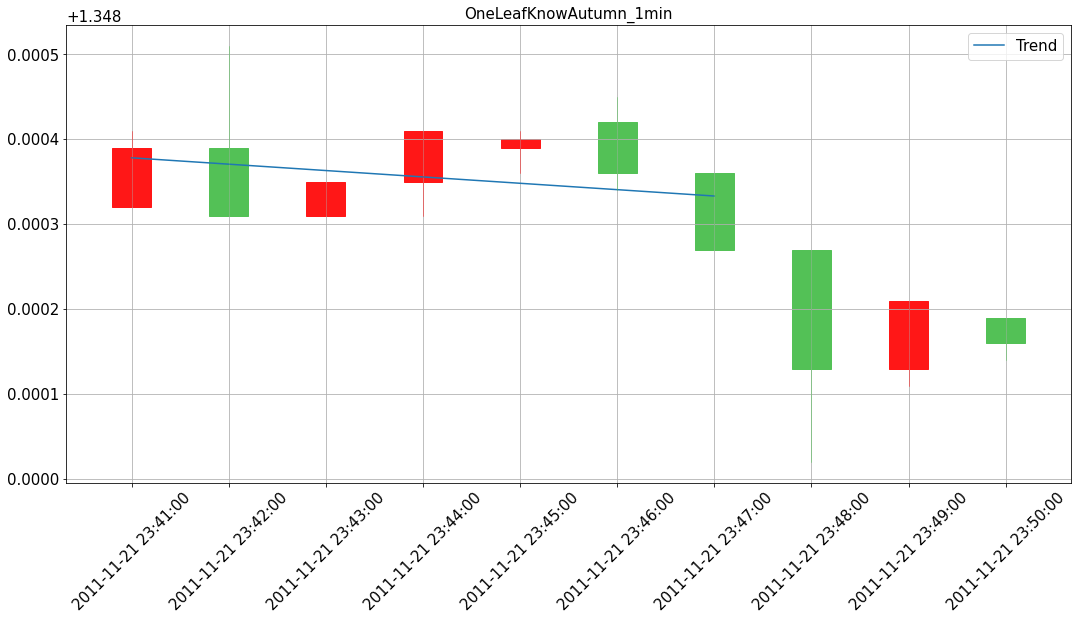

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


In [24]:
M.graph('OneLeafKnowAutumn')

GodGuideTheWay:
- 第10根上漲
- 第10根長度在前50根中PR值大於等於70
- 第10根開盤小於第9根body中央
- 第10根收盤大於第9根body收盤

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

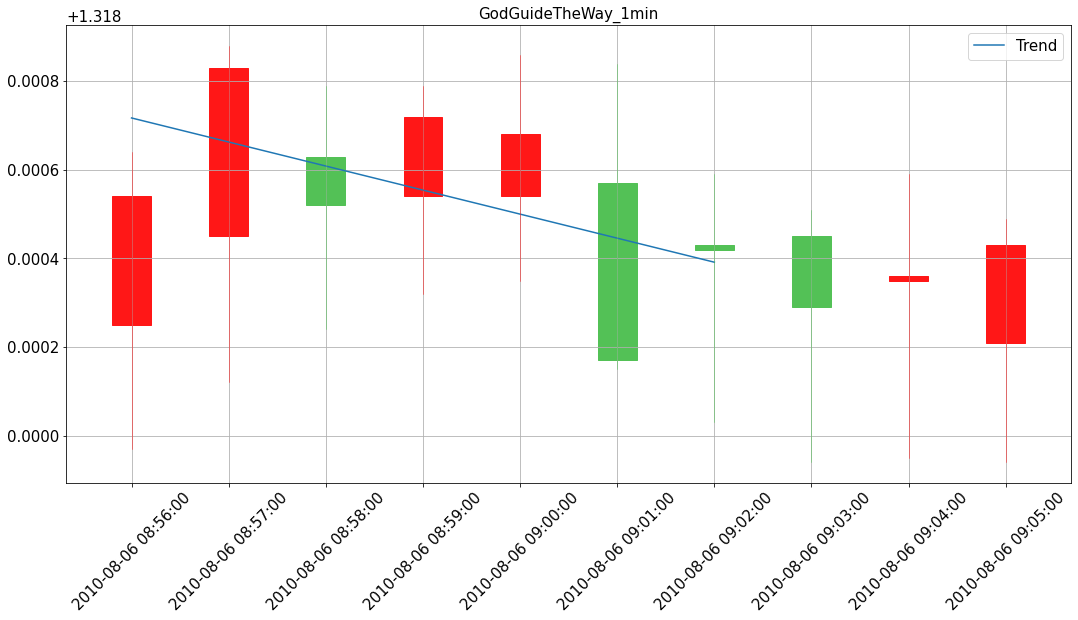

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


In [25]:
M.graph('GodGuideTheWay')

Shooting Star:  
- 前9根趨勢為正  
- 第9根上漲  
- 第9根長度在前50根中PR值大於等於65  
- 第10根上影線長度大於其body長度的兩倍  
- 第10根開盤或收盤價(較小者)大於等於第9根中央  
- 第10根下影線長度在前50根中PR值小於25  
- 第10根上影線長度在前50根中PR值大於65  

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

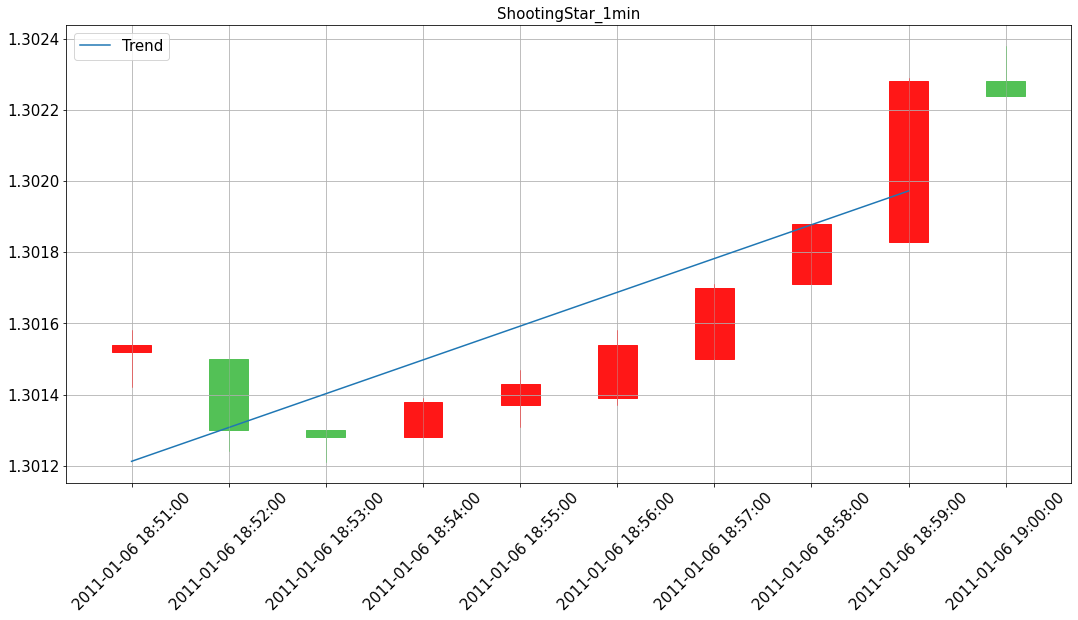

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


In [26]:
M.graph('ShootingStar')

Inverted Hammer:  
- 前9根趨勢為負  
- 第9根下跌  
- 第9根長度在前50根中PR值大於等於65  
- 第10根上影線長度大於其body長度的兩倍  
- 第10根開盤或收盤價(較大者)小於等於第9根中央  
- 第10根下影線長度在前50根中PR值小於25  
- 第10根上影線長度在前50根中PR值大於65  

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

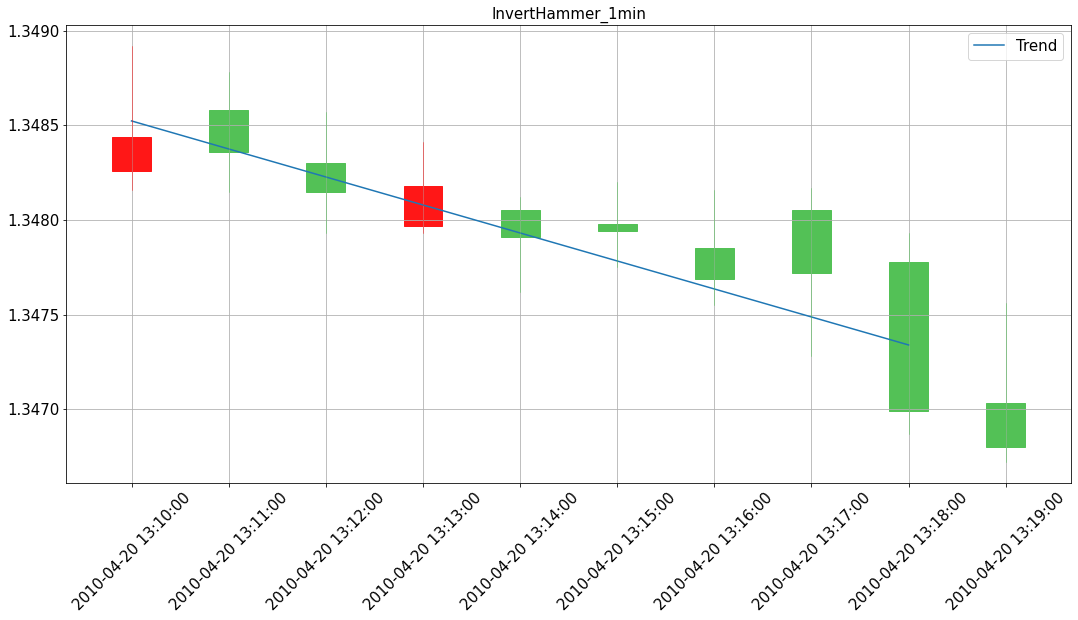

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


In [27]:
M.graph('InvertHammer')

Bearish Harami:  
- 前8根趨勢為正  
- 第9根為上漲  
- 第10根下跌  
- 第9根長度在前50根中PR值大於等於65  
- 第10根開盤價小於第9根收盤價  
- 第10根收盤價大於第9根開盤價   
- 第10根長度在前50根中PR值大於等於65  
- 第10根收盤價小於等於第9根中央  

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

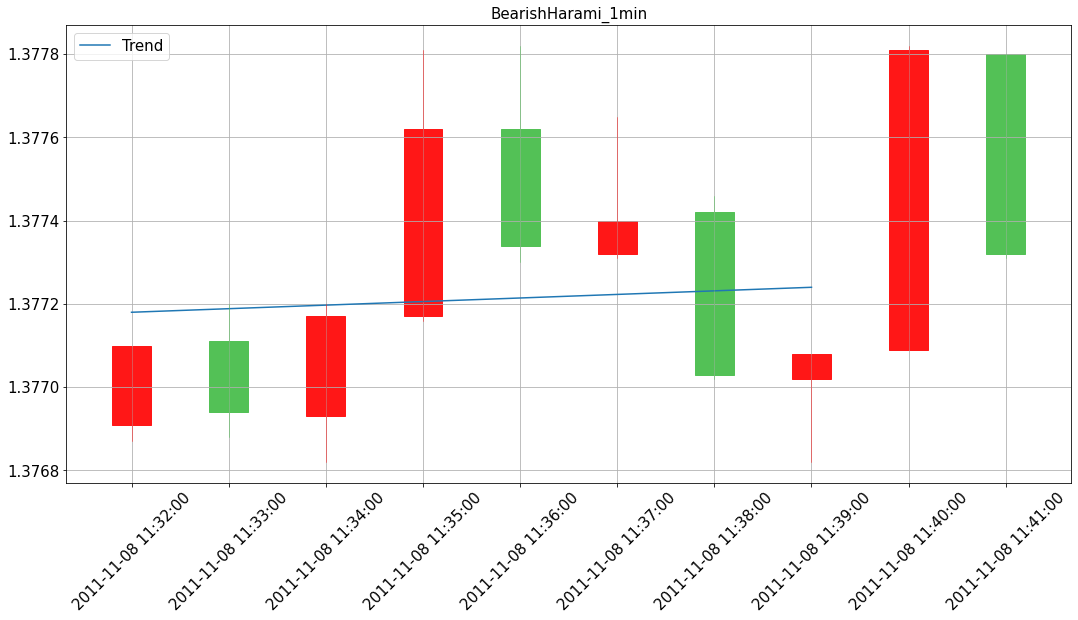

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


In [28]:
M.graph('BearishHarami')

Bearish Engulfing:  
- 前8根趨勢為正  
- 第9根為上漲  
- 第10根下跌  
- 第9根長度在前50根中PR值大於等於65  
- 第10根開盤價大於第9根收盤價  
- 第10根收盤價小於第9根開盤價  

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

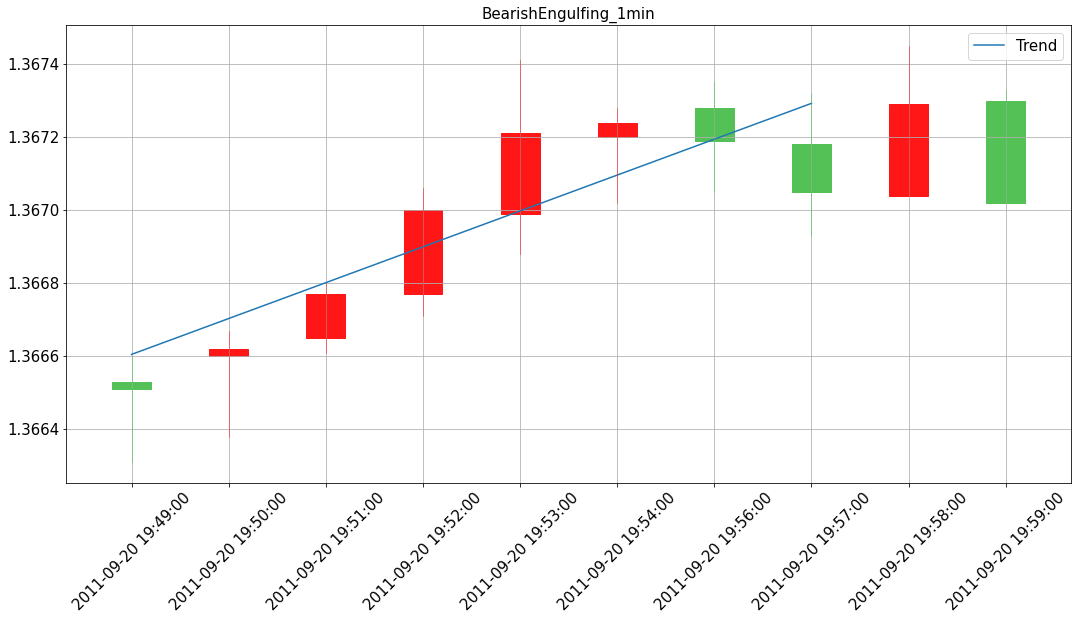

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


In [29]:
M.graph('BearishEngulfing')

Bullish Harami:  
- 前8根趨勢為負  
- 第9根為下跌  
- 第10根上漲  
- 第9根長度在前50根中PR值大於等於65  
- 第10根開盤價大於第9根收盤價  
- 第10根收盤價小於第9根開盤價  
- 第10根長度在前50根中PR值大於等於65  
- 第10根收盤價大於等於第9根中央  

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

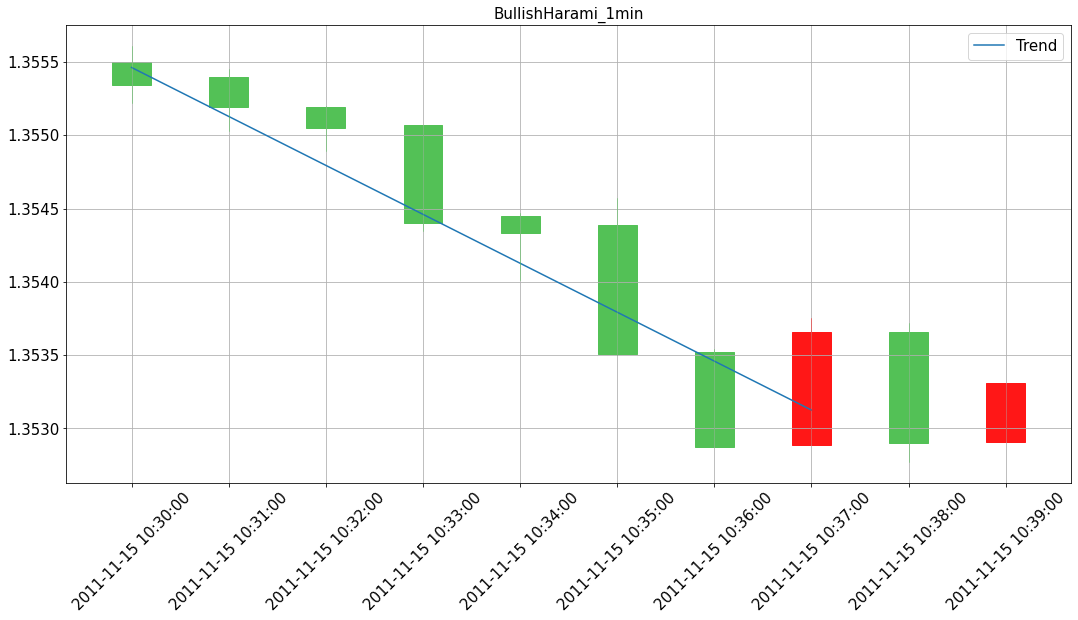

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


In [30]:
M.graph('BullishHarami')

Bullish Engulfing:  
- 前8根趨勢為負  
- 第9根為下跌  
- 第10根上漲  
- 第9根長度在前50根中PR值大於等於65  
- 第10根開盤價小於第9根收盤價  
- 第10根收盤價大於第9根開盤價   

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

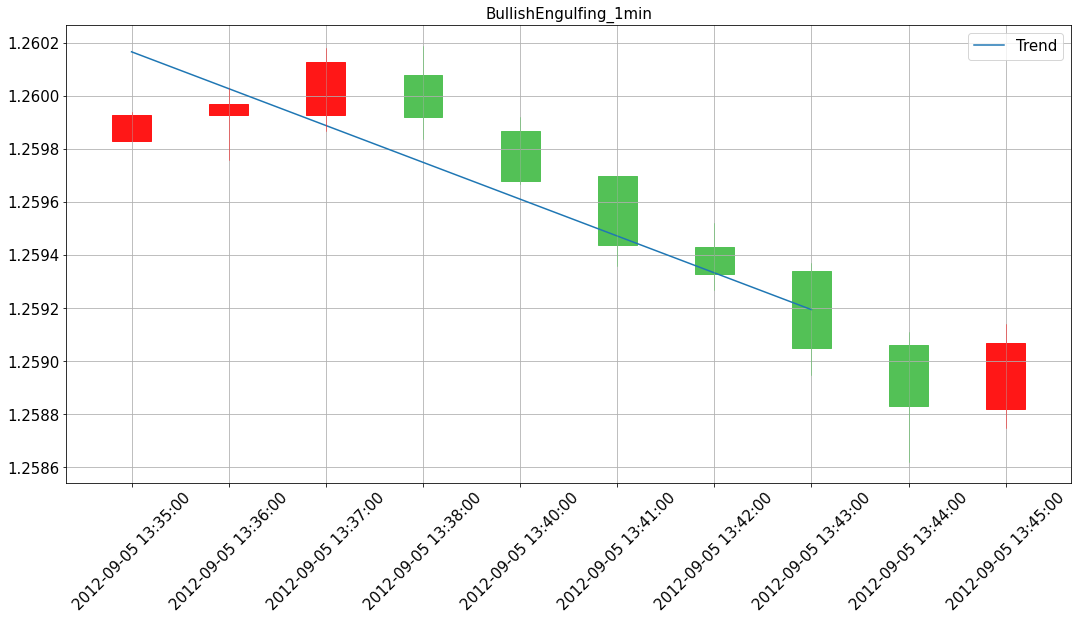

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


In [31]:
M.graph('BullishEngulfing')

## 三、參考資料

- Stephen W. Bigalow. THE MAJOR CANDLESTICKS SIGNALS “12 Signals to Master any Market”. The Candlestick Forum LLC.